In [1]:
!nvidia-smi
%matplotlib inline

Fri Jul 11 09:26:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:06:00.0 Off |                    0 |
| N/A   32C    P0             66W /  700W |       1MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
%matplotlib inline

In [3]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)
learning_A_csv = "../data/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(learning_A_csv)
learning_B_csv = "../data/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(learning_B_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# Helper functions

In [5]:
def dspy_cot_no_theory_B(lm, input_list, class_to_use):

    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")
          reasoning_list.append("error")

    return judgment_list, reasoning_list

def dspy_predict_no_theory_B(lm, input_list, class_to_use):
    judgment_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          judgment_list.append(result.judgment)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")

    return judgment_list

def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# In-context learning data loading and preprocessing
def load_data_no_theory_B(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                query=row['request'],
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples


def run_experiment_B(test_df, model_in_use, program_in_use, think_file_name, input_col='request', mode='CoT'):
  requests_to_test = test_df[input_col].tolist()

  if mode == 'CoT':
    judgment_list, reasoning_list = dspy_cot_no_theory_B(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')
  else:
    judgment_list = dspy_predict_no_theory_B(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

In [6]:
def dspy_cot_no_theory_A(lm, input_list, class_to_use):

    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")
          reasoning_list.append("error")

    return judgment_list, reasoning_list

def dspy_predict_no_theory_A(lm, input_list, class_to_use):
    judgment_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          judgment_list.append(result.judgment)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")

    return judgment_list


# In-context learning data loading and preprocessing
def load_data_no_theory_A(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment_A(test_df, model_in_use, program_in_use, think_file_name, input_col='request', mode='CoT'):
  requests_to_test = test_df[input_col].tolist()

  if mode == 'CoT':
    judgment_list, reasoning_list = dspy_cot_no_theory_A(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')
  else:
    judgment_list = dspy_predict_no_theory_A(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

# Qwen 3 4B

In [15]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

## Wording 1

## Qwen3-4B DSPy-CoT W1

In [16]:
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.ChainOfThought(Classification_no_theory)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    reasoning='The question "Who is the president?" is ambiguous because it does not specify which country\'s president is being asked about. Without additional context, it is unclear whether the user is referring to the president of the United States, another nation, or a different entity altogether.',
    judgment='underspecified'
)


In [17]:
dspy.inspect_history()





[2025-07-10T22:01:55.617915]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `reasoning` (str)
2. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## reasoning ## ]]
{reasoning}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `request`, produce the fields `judgment`.


User message:

[[ ## request ## ]]
Who is the president?

Respond with the corresponding output fields, starting with the field `[[ ## reasoning ## ]]`, then `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## 

In [18]:
experiment_result = run_experiment_A(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A_think_contents')

Processing: 100%|██████████| 1155/1155 [1:11:24<00:00,  3.71s/it]

The current length of history is 1173.
The number of thinking pieces is 1173.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.65      0.76      0.70       598
 underspecified       0.69      0.55      0.61       557

       accuracy                           0.66      1155
      macro avg       0.67      0.66      0.66      1155
   weighted avg       0.67      0.66      0.66      1155



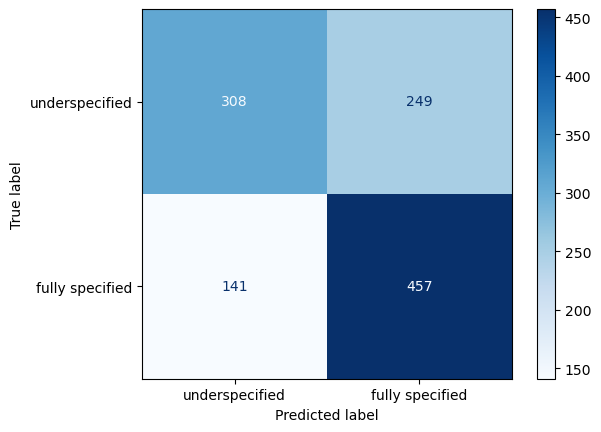

In [19]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A')

                 precision    recall  f1-score   support

fully specified       0.69      0.74      0.71       431
 underspecified       0.71      0.66      0.68       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855



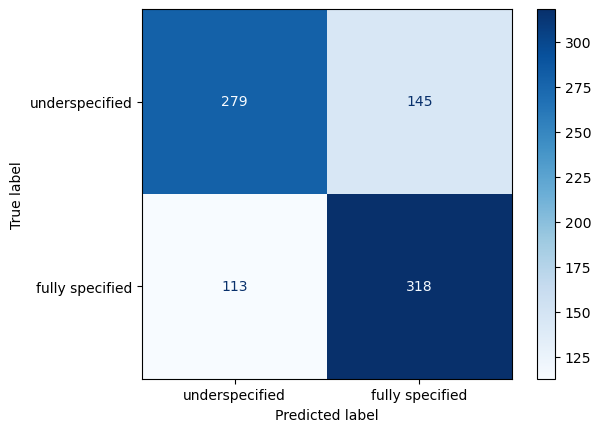

In [20]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A.csv', 'AmbigQA')

## Qwen3-4B DSPy-Predict W1

In [21]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [22]:
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.Predict(Classification_no_theory)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    judgment='underspecified'
)


In [23]:
experiment_result = run_experiment_A(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A_think_contents', mode="Predict")

Processing: 100%|██████████| 1155/1155 [57:15<00:00,  2.97s/it] 

The current length of history is 1265.
The number of thinking pieces is 1265.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.63      0.83      0.71       598
 underspecified       0.72      0.48      0.57       557

       accuracy                           0.66      1155
      macro avg       0.67      0.65      0.64      1155
   weighted avg       0.67      0.66      0.65      1155



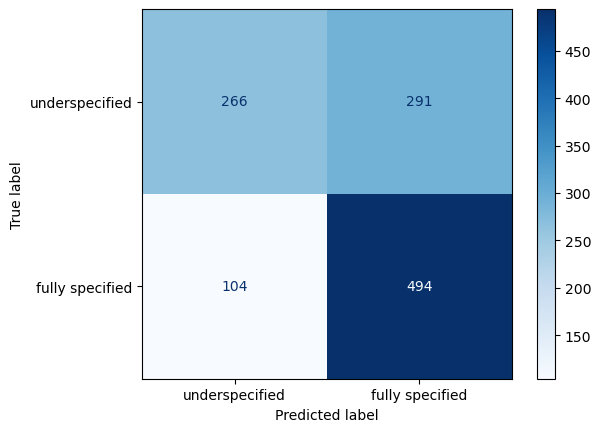

In [24]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A')

                 precision    recall  f1-score   support

fully specified       0.66      0.80      0.72       431
 underspecified       0.74      0.58      0.65       424

       accuracy                           0.69       855
      macro avg       0.70      0.69      0.69       855
   weighted avg       0.70      0.69      0.69       855



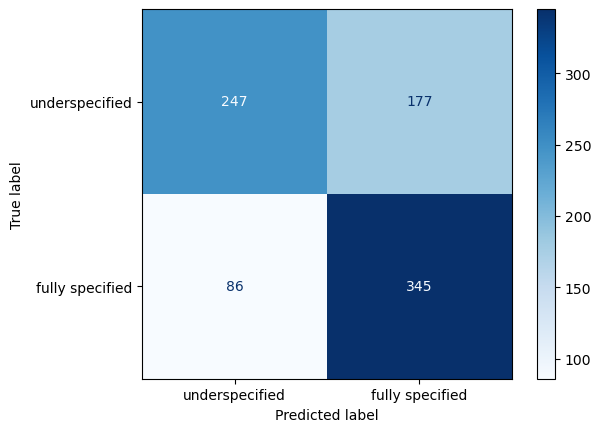

In [25]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A.csv', 'AmbigQA')

## Wording 2

## Qwen3-4B DSPy-CoT W2

In [ ]:
class Classification_no_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.ChainOfThought(Classification_no_theory)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    reasoning='The query "Who is the president?" is ambiguous because it does not specify which country, organization, or context the question refers to. The term "president" can apply to multiple entities (e.g., United States, a company, a university, etc.), and without additional context, the question lacks the necessary specificity to determine a unique answer.',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()





[2025-06-27T10:27:17.166417]

System message:

Your input fields are:
1. `query` (str): An input user query.

Your output fields are:
1. `reasoning` (str)
2. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## reasoning ## ]]
{reasoning}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `query`, produce the fields `judgment`.


User message:

[[ ## query ## ]]
Who is the president?

Respond with the corresponding output fields, starting with the field `[[ ## reasoning ## ]]`, then `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## completed ## ]]`.


R

In [ ]:
experiment_result = run_experiment(df_test_1155, model, program, 'Qwen3_4B_DSPy_FS_UND_think_contents')

Processing: 100%|██████████| 1155/1155 [1:13:01<00:00,  3.79s/it]

The current length of history is 1169.
The number of thinking pieces is 1169.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.65      0.78      0.71       598
 underspecified       0.70      0.55      0.62       557

       accuracy                           0.67      1155
      macro avg       0.68      0.67      0.66      1155
   weighted avg       0.67      0.67      0.66      1155



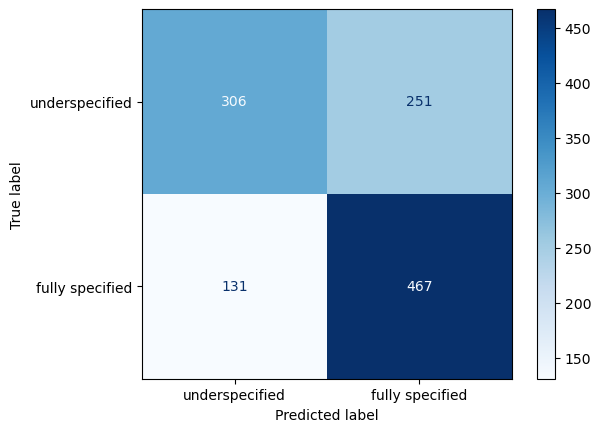

In [ ]:
retrieve_results(experiment_result, 'Qwen3_4B_DSPy_FS_UND')

                 precision    recall  f1-score   support

fully specified       0.69      0.75      0.72       431
 underspecified       0.72      0.65      0.68       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855



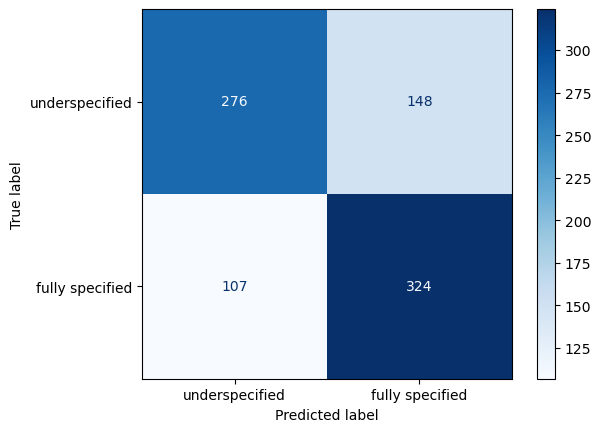

In [ ]:
obtain_results_without('Qwen3_4B_DSPy_FS_UND.csv', 'AmbigQA')

## Qwen3-4B DSPy-Predict W2

In [ ]:
class Classification_no_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.Predict(Classification_no_theory)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    judgment='underspecified'
)


In [ ]:
experiment_result = run_experiment_B(df_test_1155, model, program, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_B_think_contents', mode='Predict')

Processing: 100%|██████████| 1155/1155 [57:54<00:00,  3.01s/it] 

The current length of history is 1347.
The number of thinking pieces is 1347.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.64      0.79      0.71       598
 underspecified       0.70      0.52      0.59       557

       accuracy                           0.66      1155
      macro avg       0.67      0.65      0.65      1155
   weighted avg       0.67      0.66      0.65      1155



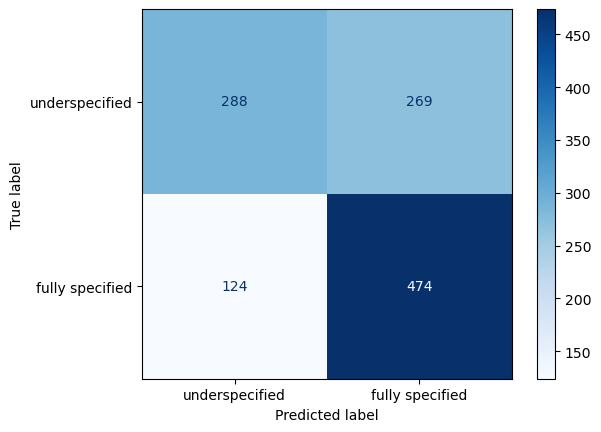

In [ ]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_B')

                 precision    recall  f1-score   support

fully specified       0.66      0.77      0.71       431
 underspecified       0.72      0.59      0.65       424

       accuracy                           0.68       855
      macro avg       0.69      0.68      0.68       855
   weighted avg       0.69      0.68      0.68       855



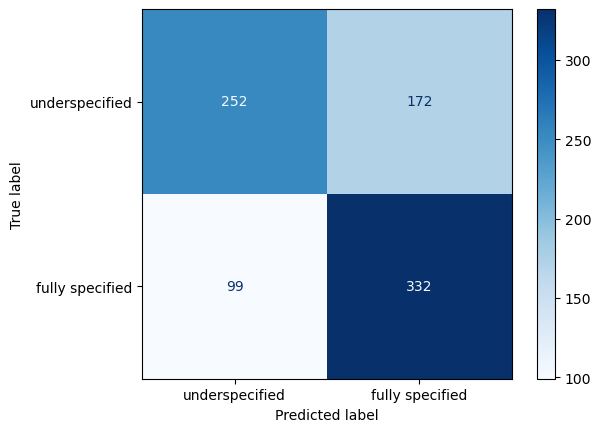

In [ ]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_Predict_no_theory_no_example_wording_B.csv', 'AmbigQA')

# Llama 3.3 70B

In [ ]:
# Command line input for setting scratch space as cache path
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate

# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs


# launching
huggingface-cli login

CUDA_VISIBLE_DEVICES=0,1,2,3 python -m sglang.launch_server --port 7501 --model-path meta-llama/Llama-3.3-70B-Instruct --tensor-parallel-size 4
"""

In [19]:
model = dspy.LM("openai/meta-llama/Llama-3.3-70B-Instruct",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

## Wording 1

## Llama-3.3-70B-Instruct DSPy-CoT W1

In [21]:
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.ChainOfThought(Classification_no_theory)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    reasoning='The question "Who is the president?" is ambiguous because it does not specify the country or time period. There are many presidents around the world and throughout history, so without more context, it is impossible to provide a specific answer.',
    judgment='underspecified'
)


In [22]:
dspy.inspect_history()





[2025-07-11T10:48:02.625738]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `reasoning` (str)
2. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## reasoning ## ]]
{reasoning}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `request`, produce the fields `judgment`.


User message:

[[ ## request ## ]]
Who is the president?

Respond with the corresponding output fields, starting with the field `[[ ## reasoning ## ]]`, then `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## 

In [23]:
experiment_result = run_experiment_A(df_test_1155, model, program, 'Llama_70B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A_think_contents')

Processing: 100%|██████████| 1155/1155 [47:06<00:00,  2.45s/it] 

The current length of history is 1159.
The number of thinking pieces is 1159.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.66      0.74      0.69       598
 underspecified       0.67      0.59      0.63       557

       accuracy                           0.66      1155
      macro avg       0.67      0.66      0.66      1155
   weighted avg       0.67      0.66      0.66      1155



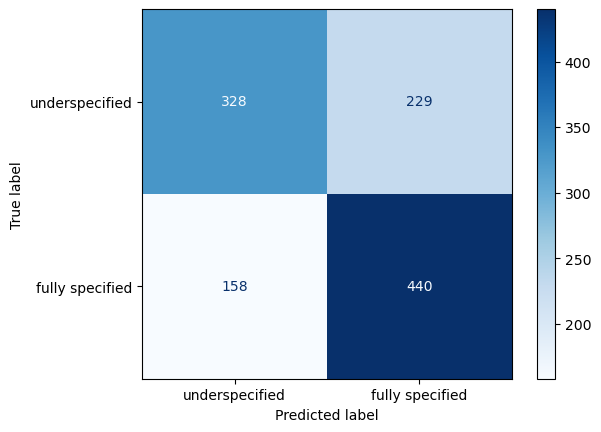

In [24]:
retrieve_results(experiment_result, 'Llama_70B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A')

                 precision    recall  f1-score   support

fully specified       0.68      0.69      0.69       431
 underspecified       0.68      0.68      0.68       424

       accuracy                           0.68       855
      macro avg       0.68      0.68      0.68       855
   weighted avg       0.68      0.68      0.68       855



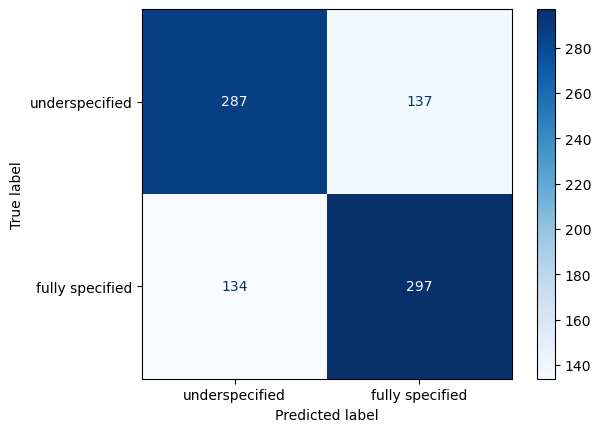

In [25]:
obtain_results_without('Llama_70B_UND_FS_DSPy_CoT_no_theory_no_example_wording_A.csv', 'AmbigQA')

## Llama-3.3-70B-Instruct DSPy-Predict W1

In [26]:
model = dspy.LM("openai/meta-llama/Llama-3.3-70B-Instruct",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [28]:
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.Predict(Classification_no_theory)

# One-shot Testing
result = program(request="Who is the president?")
print(result)

Prediction(
    judgment='underspecified'
)


In [29]:
dspy.inspect_history()





[2025-07-11T11:35:41.259715]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `request`, produce the fields `judgment`.


User message:

[[ ## request ## ]]
Who is the president?

Respond with the corresponding output fields, starting with the field `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## completed ## ]]`.


Response:

[[ ## judgment ## ]]
underspecified
[[ ## completed ## 

In [30]:
experiment_result = run_experiment_A(df_test_1155, model, program, 'Llama_70B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A_think_contents', mode="Predict")

Processing: 100%|██████████| 1155/1155 [07:28<00:00,  2.57it/s] 

The current length of history is 1170.
The number of thinking pieces is 1170.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.63      0.77      0.69       598
 underspecified       0.67      0.51      0.58       557

       accuracy                           0.64      1155
      macro avg       0.65      0.64      0.64      1155
   weighted avg       0.65      0.64      0.64      1155



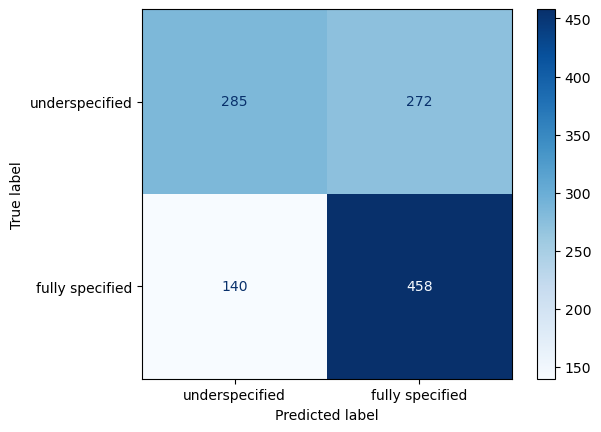

In [31]:
retrieve_results(experiment_result, 'Llama_70B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A')

                 precision    recall  f1-score   support

fully specified       0.65      0.73      0.69       431
 underspecified       0.69      0.60      0.64       424

       accuracy                           0.67       855
      macro avg       0.67      0.67      0.67       855
   weighted avg       0.67      0.67      0.67       855



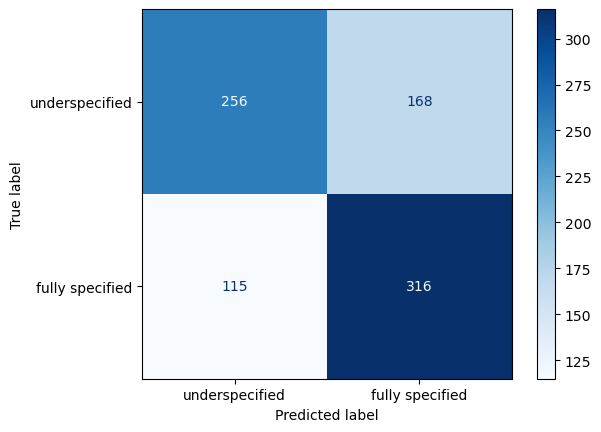

In [32]:
obtain_results_without('Llama_70B_UND_FS_DSPy_Predict_no_theory_no_example_wording_A.csv', 'AmbigQA')

## Wording 2

## Llama-3.3-70B-Instruct DSPy-CoT W2

In [ ]:
class Classification_no_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.ChainOfThought(Classification_no_theory)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    reasoning='The query "Who is the president?" lacks specific details about which country or time period the user is inquiring about, as there are many presidents around the world and throughout history.',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()





[2025-07-10T13:30:37.543602]

System message:

Your input fields are:
1. `query` (str): An input user query.

Your output fields are:
1. `reasoning` (str)
2. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## reasoning ## ]]
{reasoning}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `query`, produce the fields `judgment`.


User message:

[[ ## query ## ]]
Who is the president?

Respond with the corresponding output fields, starting with the field `[[ ## reasoning ## ]]`, then `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## completed ## ]]`.


R

In [ ]:
experiment_result = run_experiment_B(df_test_1155, model, program, 'Llama_70B_DSPy_CoT_think_contents')

Processing: 100%|██████████| 1155/1155 [45:15<00:00,  2.35s/it] 

The current length of history is 1158.
The number of thinking pieces is 1158.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.66      0.77      0.71       598
 underspecified       0.70      0.58      0.63       557

       accuracy                           0.67      1155
      macro avg       0.68      0.67      0.67      1155
   weighted avg       0.68      0.67      0.67      1155



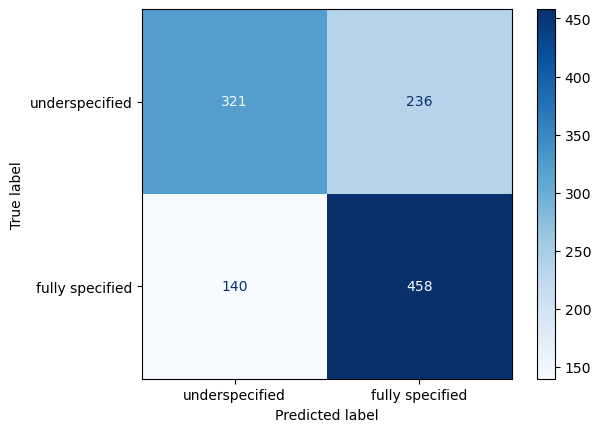

In [ ]:
retrieve_results(experiment_result, 'Llama_70B_DSPy_CoT_FS_UND')

                 precision    recall  f1-score   support

fully specified       0.69      0.73      0.71       431
 underspecified       0.71      0.67      0.69       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855



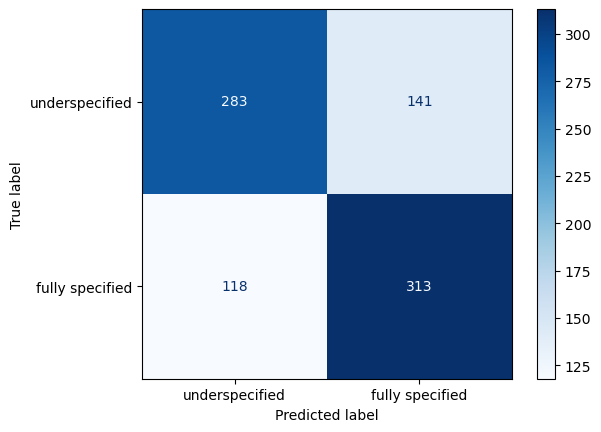

In [ ]:
obtain_results_without('Llama_70B_DSPy_CoT_FS_UND.csv', 'AmbigQA')

## Llama-3.3-70B-Instruct DSPy-Predict W2

In [ ]:
model = dspy.LM("openai/meta-llama/Llama-3.3-70B-Instruct",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [ ]:
class Classification_no_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

program = dspy.Predict(Classification_no_theory)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    judgment='underspecified'
)


In [ ]:
experiment_result = run_experiment_B(df_test_1155, model, program, 'Llama_70B_DSPy_Predict_think_contents', mode="Predict")

Processing: 100%|██████████| 1155/1155 [06:57<00:00,  2.77it/s] 

The current length of history is 1177.
The number of thinking pieces is 1177.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.63      0.68      0.65       598
 underspecified       0.62      0.58      0.60       557

       accuracy                           0.63      1155
      macro avg       0.63      0.63      0.63      1155
   weighted avg       0.63      0.63      0.63      1155



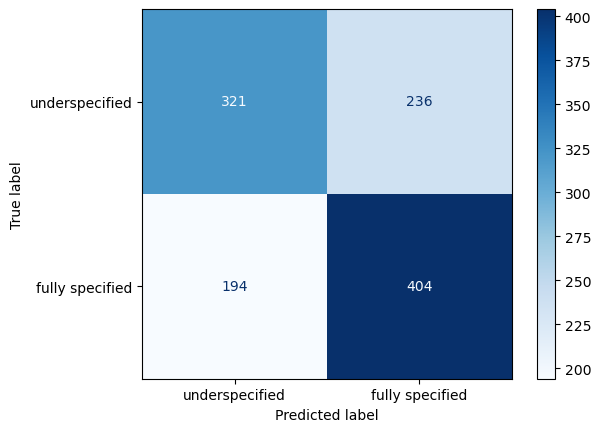

In [ ]:
retrieve_results(experiment_result, 'Llama_70B_DSPy_Predict_FS_UND')

                 precision    recall  f1-score   support

fully specified       0.66      0.63      0.64       431
 underspecified       0.64      0.66      0.65       424

       accuracy                           0.65       855
      macro avg       0.65      0.65      0.65       855
   weighted avg       0.65      0.65      0.65       855



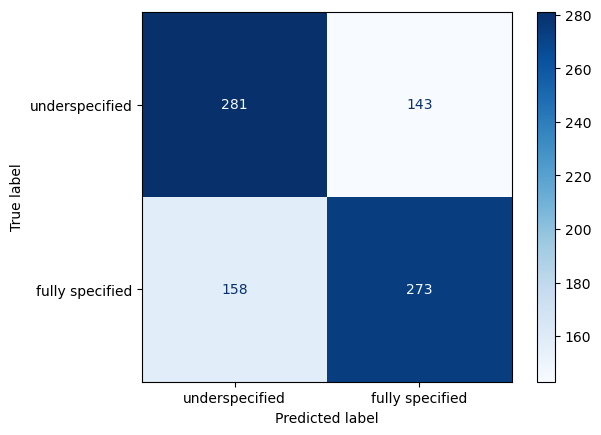

In [ ]:
obtain_results_without('Llama_70B_DSPy_Predict_FS_UND.csv', 'AmbigQA')